In [90]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from gensim.models import FastText
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [91]:
sentimen_data = pd.read_csv('../data/Indonesian Sentiment Twitter Dataset Labeled.csv', sep="\t")
sentimen_data.head()

,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...


In [92]:
alay_dict = pd.read_csv("../data/new_kamusalay.csv", encoding = 'latin-1', header=None)
alay_dict = alay_dict.rename(columns=  {0: 'original',
                                        1: 'replacement'})
stopword_dict = pd.read_csv('../data/stopwordbahasa.csv', header=None)
stopword_dict = stopword_dict.rename(columns={0: 'stopword'})

In [93]:
sentimen_data.isnull().sum()

sentimen    0
Tweet       0
dtype: int64

In [94]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#lowercase
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('((@[^\s]+)|(#[^\s]+))',' ',text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = lowercase(text) # 1
    text = remove_unnecessary_char(text) # 2
    text = remove_nonaplhanumeric(text) # 3
    text = normalize_alay(text) # 4
    text = remove_stopword(text) # 5
    text = stemming(text) # 6
    return text

In [95]:
sentimen_data.replace(-1, 0, inplace=True)

In [96]:
X = sentimen_data['Tweet'].apply(preprocess)

In [97]:
sentimen_data.head()

,sentimen,Tweet
0,0,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,0,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,0,aku tak faham betul jenis orang malaysia yang ...


In [98]:
tweets = sentimen_data['Tweet'].values
sentiments = sentimen_data['sentimen'].values

In [99]:
max_features = 1000
max_len=50
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, padding='post', maxlen=max_len)
X.shape

(10806, 50)

In [100]:
sentiment_encode = {-1 : 0, 0 : 1, 1 : 2}
y = sentimen_data['sentimen'].map(sentiment_encode).values
print(sentimen_data['sentimen'])
print(y)

0        0
1        0
2        1
3        1
4        0
        ..
10801    1
10802    0
10803    1
10804    1
10805    1
Name: sentimen, Length: 10806, dtype: int64
[1 1 2 ... 2 2 2]


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7348, 50) (7348, 3)
(1621, 50) (1621, 3)


In [102]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

# Pad sequences
max_seq_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)

# Train FastText
model_ft = FastText([seq.split() for seq in tweets], vector_size=150, window=5, min_count=3, epochs=100)

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 150))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_ft.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        continue


In [103]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs=1

# Convert sentiments to binary labels
binary_labels = np.array([1 if x == 1 else 0 for x in sentiments])

# Train model
history = model.fit(padded_sequences, binary_labels, epochs=epochs, batch_size=1)

# batch_size = 64
# model.fit(X_train, y_train,
#                       validation_data=(X_val, y_val),
#                       batch_size=batch_size, epochs=epochs, verbose=2)

10806/10806 [==============================] - 114s 10ms/step - loss: 0.5003 - accuracy: 0.7747


KeyError: 'val_accuracy'

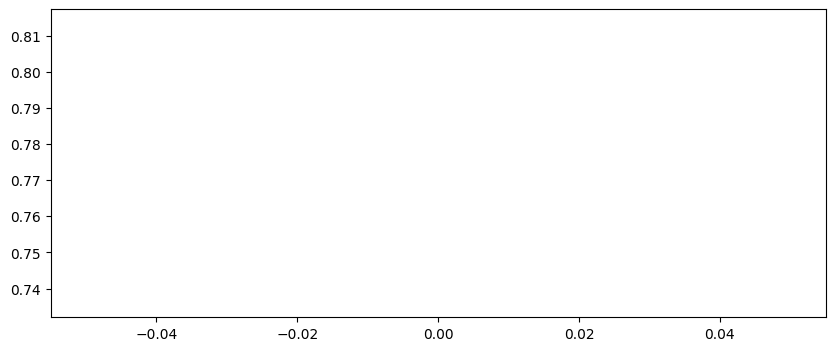

In [104]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(history.history['accuracy'], label = 'train accuracy')
ax.plot(history.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()